In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import json
import pickle
from collections import defaultdict
%matplotlib inline

In [2]:
np.random.seed(21)

In [3]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Activation, Cropping2D, Reshape, BatchNormalization
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras.losses import mean_squared_error, categorical_crossentropy
from keras.preprocessing.image import Iterator
from keras.utils.np_utils import to_categorical
from keras.layers import Reshape, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

import tensorflow as tf
sess = tf.Session()
K.set_session(sess)

Using TensorFlow backend.


In [4]:
from __future__ import absolute_import
from __future__ import print_function

from pkg_resources import parse_version
from keras.callbacks import Callback

In [5]:
class TensorBoardCallBack(Callback):
    """Tensorboard basic visualizations.
    This callback writes a log for TensorBoard, which allows
    you to visualize dynamic graphs of your training and test
    metrics, as well as activation histograms for the different
    layers in your model.
    TensorBoard is a visualization tool provided with TensorFlow.
    If you have installed TensorFlow with pip, you should be able
    to launch TensorBoard from the command line:
    ```
    tensorboard --logdir=/full_path_to_your_logs
    ```
    You can find more information about TensorBoard
    [here](https://www.tensorflow.org/versions/master/how_tos/summaries_and_tensorboard/index.html).
    # Arguments
        log_dir: the path of the directory where to save the log
            files to be parsed by Tensorboard
        batch_freq: frequency (in batch) at which to log data
            If set to 0, we just log at the end of an epoch,
    """

    def __init__(self, log_dir='./logs',
                 batch_freq=0):
        super(TensorBoardCallBack, self).__init__()

        self.log_dir = log_dir
        self.batch_freq = batch_freq
        self.merged = None
        self.writer = tf.summary.FileWriter(self.log_dir)
        self.last_batch = 0
        self.batch_offset = 0

    def set_model(self, model):
        self.model = model
        self.sess = K.get_session()

        if hasattr(tf, 'merge_all_summaries'):
            self.merged = tf.merge_all_summaries()
        else:
            self.merged = tf.summary.merge_all()

    def on_batch_end(self, batch, logs=None):
        # Each time we go back to batch 0, we increase the batch_offset
        if batch < self.last_batch:
            self.batch_offset += self.last_batch + 1
        self.last_batch = batch

        batch_cross_epoch = self.batch_offset + batch
        if batch_cross_epoch % self.batch_freq == 0:
            logs = logs or {}

            for name, value in logs.items():
                if name in ['batch', 'size']:
                    continue
                summary = tf.Summary()
                summary_value = summary.value.add()
                summary_value.simple_value = value.item()
                summary_value.tag = name
                self.writer.add_summary(summary, batch_cross_epoch)
            self.writer.flush()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for name, value in logs.items():
            if name in ['batch', 'size']:
                continue
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.writer.add_summary(summary, epoch)
        self.writer.flush()

    def on_train_end(self, _):
        self.writer.close()

In [6]:
def unet_down_block(x, n_filters, block_id, with_maxpool=True, activation="elu"):
    y = Conv2D(n_filters, (3, 3), activation=activation, 
               padding='same', name="conv{}_1".format(block_id))(x)
    y = BatchNormalization(name="bn{}_1".format(block_id))(y)
    
    y = Conv2D(n_filters, (3, 3), activation=activation,
               padding='same', name="conv{}_2".format(block_id))(y)
    conv = BatchNormalization(name="bn{}_2".format(block_id))(y)
    
    if not with_maxpool:
        return conv
    
    pool = MaxPooling2D(pool_size=(2, 2), name="max_pool{}".format(block_id))(conv)   
    return conv, pool    

In [61]:
def get_lowiknet(height, width, n_channels=3, n_classes=5,
             n_filters=[64, 128, 256, 512, 1024]):
    inputs = Input((height, width, n_channels))
    
    conv1, pool1 = unet_down_block(inputs, n_filters[0], 1)
    conv2, pool2 = unet_down_block(pool1,  n_filters[1], 2)
    conv3, pool3 = unet_down_block(pool2,  n_filters[2], 3)
    conv4, pool4 = unet_down_block(pool3,  n_filters[3], 4)
    conv5 = unet_down_block(pool4, n_filters[4], 5, with_maxpool=False)
    conv5 = Flatten()(conv5)
    counts = Dense(n_classes, activation='relu')(conv5)
    model = Model(inputs=[inputs], outputs=[counts])

    return model

In [293]:
sealion_net = get_lowiknet(512, 512, 3, n_filters=[32, 64, 128, 256, 512])

In [294]:
t = np.ones((1, 512, 512, 3))
sealion_net.predict(t).shape

(1, 5)

In [295]:
sealion_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 512, 512, 32)      896       
_________________________________________________________________
bn1_1 (BatchNormalization)   (None, 512, 512, 32)      128       
_________________________________________________________________
conv1_2 (Conv2D)             (None, 512, 512, 32)      9248      
_________________________________________________________________
bn1_2 (BatchNormalization)   (None, 512, 512, 32)      128       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 256, 256, 32)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 256, 256, 64)      18496     
__________

In [296]:
class CountsIterator(Iterator):
    def __init__(self, root_dir, image_ids,
                 n_samples_per_image=160,
                 target_size=(512, 512),
                 batch_size=16, shuffle=True, seed=42, debug_dir=None):
        
        self.n_sealion_types = 5
        self.image_ids = image_ids
        self.root_dir = root_dir
        self.debug_dir = debug_dir
        self.n_samples_per_block = 4
        self.n_samples_per_image = n_samples_per_image
        self.target_size = target_size
        self.n_indices = len(self.image_ids) * self.n_samples_per_image
                 
        super(CountsIterator, self).__init__(self.n_indices, batch_size//self.n_samples_per_block, shuffle, seed)
    
    def normalize_input(self, x_bgr):
        x = x_bgr.copy()
        x[..., 0] -= 103.939
        x[..., 1] -= 116.779
        x[..., 2] -= 123.68
        return x
    
    def denormalize_input(self, x_normed):
        x = x_normed.copy()
        x[..., 0] += 103.939
        x[..., 1] += 116.779
        x[..., 2] += 123.68
        return x

    def random_transform(self, im):
        flips = np.random.randint(0, 2, (3,))
        if flips[0]:
            x = np.rot90(x)
            y = np.rot90(y)
        if flips[1]:
            x = np.flipud(x)
            y = np.flipud(y)
        if flips[2]:
            x = np.fliplr(x)
            y = np.fliplr(y)
        return x, y
    
    def sample(self, im, dots):
        margin = 60
        h, w, c = im.shape
        adots = [d for ds in dots for d in ds]
        rds = np.random.randint(0, len(adots) + 1, size=((self.n_samples_per_block,)))
        batch_x = np.zeros((self.n_samples_per_block, self.target_size[0], self.target_size[1], 3), dtype=np.float32)
        batch_y = np.zeros((self.n_samples_per_block, 5), dtype=np.float32)
        
        n_samples = 0
        while n_samples < self.n_samples_per_block:
            rand_idx = np.random.randint(0, len(adots) + 1, size=((1,)))[0]
            if rand_idx < len(adots):
                x, y = adots[rand_idx]
                xmin = max(0, min(w - self.target_size[1], x - self.target_size[1] + margin))
                xmax = max(0, min(w - self.target_size[1], x - margin))
                ymin = max(0, min(h - self.target_size[0], y - self.target_size[0] + margin))
                ymax = max(0, min(h - self.target_size[0], y - margin))
                if xmin >= xmax or ymin >= ymax:
                    continue
            else:
                xmin, xmax = 0, w - self.target_size[1]
                ymin, ymax = 0, h - self.target_size[0]
            xs = np.random.randint(xmin, xmax, size=(1,))[0]
            ys = np.random.randint(ymin, ymax, size=(1,))[0]
            counts = self.get_counts(xs, ys, dots)                    
            batch_x[n_samples, ...] = im[ys:ys+self.target_size[0], xs:xs+self.target_size[1],...]
            batch_y[n_samples, ...] = np.asarray(counts, dtype=np.float32)
            n_samples += 1
            
        return batch_x, batch_y
    
    def get_counts(self, xstart, ystart, dots):
        x1 = xstart
        y1 = ystart
        x2 = xstart + self.target_size[1]
        y2 = ystart + self.target_size[0]
        counts = [0, 0, 0, 0, 0]
        for i, ds in enumerate(dots):
            for (x, y) in ds:
                if x1 <= x < x2 and y1 <= y < y2:
                    counts[i] += 1
        return counts
        
    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
                
        batch_x = np.zeros((current_batch_size * self.n_samples_per_block,
                            self.target_size[0],
                            self.target_size[1],
                            3),
                           dtype=K.floatx())
        batch_y = np.zeros((current_batch_size * self.n_samples_per_block, 5),
                           dtype=np.int32)
        
        # For each index, we load the data and sample randomly n_successive_samples patches
        for i, j in enumerate(index_array):
            index = j // self.n_samples_per_image
            image_id = self.image_ids[index]
            with open(os.path.join(self.root_dir, "TrainDots", str(image_id) + ".pkl"), "rb") as pfile:
                dots = pickle.load(pfile)
            im = cv2.imread(os.path.join(self.root_dir, "Train", str(image_id) + ".jpg"))
                
            x, y = self.sample(im, dots)
            batch_x[i*self.n_samples_per_block:(i+1)*self.n_samples_per_block, ...] = x
            batch_y[i*self.n_samples_per_block:(i+1)*self.n_samples_per_block, ...] = y 

        if self.debug_dir:
            for i in range(batch_x.shape[0]):
                cv2.imwrite(os.path.join(self.debug_dir, "patch_{}.jpg".format(i)), batch_x[i])
        
        return self.normalize_input(batch_x), batch_y

In [297]:
with open("../data/train.json", "r") as jfile:
    train_ids = json.load(jfile)
train_ids = [int(iid) for iid in train_ids]

with open("../data/val.json", "r") as jfile:
    val_ids = json.load(jfile)
val_ids = [int(iid) for iid in val_ids]

In [298]:
trainCountsIterator = CountsIterator("/home/ubuntu/sealion/data/", train_ids)

valCountsIterator = CountsIterator("/home/ubuntu/sealion/data/", val_ids)

In [299]:
for i, (batch_x, batch_y) in enumerate(trainCountsIterator):
    break

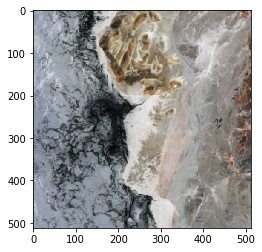

In [300]:
plt.imshow(trainCountsIterator.denormalize_input(batch_x[2, ...]))

In [301]:
batch_y

array([[ 1,  2, 12,  4,  0],
       [ 1,  2, 11,  5,  0],
       [ 1,  2, 13,  5,  0],
       [ 1,  2, 14,  5,  0],
       [ 0,  1,  0,  0,  0],
       [ 0,  3,  0,  0,  0],
       [ 1,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0],
       [ 0,  1,  0,  4,  0],
       [ 0,  2,  0,  5,  0],
       [ 0,  2,  0,  5,  0],
       [ 0,  2,  0,  4,  0],
       [ 1,  0, 33, 48,  0],
       [ 1,  2, 38, 24,  0],
       [ 1,  2,  9,  6,  0],
       [ 1,  0, 31, 43,  0]], dtype=int32)

In [302]:
bpred = sealion_net.predict(batch_x)

In [303]:
bpred

array([[ 0.        ,  1.14133728,  0.        ,  2.55994344,  0.67194194],
       [ 0.        ,  0.17807379,  0.        ,  2.34059525,  1.20077181],
       [ 0.0081656 ,  1.02078664,  0.        ,  2.64847565,  0.        ],
       [ 0.05725645,  0.70532876,  0.        ,  3.16509557,  0.80058968],
       [ 0.        ,  1.25079525,  0.        ,  1.54682744,  0.14873834],
       [ 0.        ,  0.21422642,  0.        ,  1.16818869,  0.39839977],
       [ 0.        ,  1.0837239 ,  0.        ,  1.48518407,  0.07764985],
       [ 0.        ,  1.38471842,  0.        ,  2.06236386,  1.01415205],
       [ 0.        ,  1.27948582,  0.        ,  2.42386436,  0.17077315],
       [ 0.        ,  0.86573982,  0.        ,  2.470052  ,  0.        ],
       [ 0.44236359,  1.79697919,  0.        ,  2.55689597,  0.09087398],
       [ 0.12220459,  1.12557876,  0.        ,  1.7279669 ,  0.47935095],
       [ 0.        ,  0.24957973,  0.        ,  3.22883725,  0.322348  ],
       [ 0.        ,  0.64430964,  0. 

In [304]:
with sess.as_default():
    print(np.mean(mean_squared_error(bpred, batch_y).eval()))

104.702810791


In [305]:
sgd = SGD(lr=1e-5 , momentum=0.9, decay=1e-6, nesterov=True)
sealion_net.compile(optimizer=sgd, loss=mean_squared_error)

In [306]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

cb_checkpoint = ModelCheckpoint("/home/ubuntu/data/sealion/data/models/lowik_cnt_net/ckpt_{epoch:02d}-{val_loss:.2f}.h5")
cb_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', epsilon=0.01, cooldown=0, min_lr=0)
tensorboard_cb = TensorBoardCallBack(log_dir="/home/ubuntu/data/sealion/data/models/lowik_cnt_net/log_tb", batch_freq=10)

In [307]:
h = sealion_net.fit_generator(trainCountsIterator, 1000, epochs=20,
                              verbose=1, callbacks=[cb_checkpoint, cb_reduce_lr, tensorboard_cb],
                              validation_data=valCountsIterator, validation_steps=200,
                              class_weight=None,
                              max_q_size=4, workers=4, pickle_safe=False,
                              initial_epoch=0)

Epoch 1/20
 171/1000 [====>.........................] - ETA: 1833s - loss: 51.2100

KeyboardInterrupt: 

In [ ]:
for batch_x, batch_y in valCountsIterator:
    break

In [ ]:
batch_x.shape

In [ ]:
batch_y.shape

In [ ]:
bpred = sealion_net.predict(batch_x)

In [ ]:
bpred

In [ ]:
i = 7
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(valPatchesGenerator.denormalize_input(batch_x[i,:,:, :]))
plt.subplot(132)
plt.imshow(np.argmax(batch_y[i,...], axis=-1))
plt.subplot(133)
plt.imshow(np.argmax(bpred[i,...], axis=-1))

In [ ]:
classes_counts = trainPatchesGenerator.compute_class_distribution(100)

In [ ]:
classes_counts

In [ ]:
mcount = np.median(classes_counts)

In [ ]:
weights_per_class = mcount/classes_counts

In [ ]:
weights_per_class

In [ ]:
def w_categorical_crossentropy(y_true, y_pred):
    y_true_r = K.reshape(y_true, (8, 212*212, 6))
    y_pred_r = K.reshape(y_pred, (8, 212*212, 6))
    weights = K.max(y_true_r * weights_per_class, axis=-1)
    loss_per_pixel = K.categorical_crossentropy(y_pred_r, y_true_r)
    return loss_per_pixel * weights

In [ ]:
cb_checkpoint = ModelCheckpoint("/home/ubuntu/data/sealion/data/models/segmentation/ckpt_{epoch:02d}-{val_loss:.2f}.h5")
cb_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', epsilon=0.01, cooldown=0, min_lr=0)
tensorboard_cb = TensorBoardCallBack(log_dir="/home/ubuntu/data/sealion/data/models/segmentation/log_tb", batch_freq=10)

In [ ]:
sgd = SGD(lr=1e-2, momentum=0.9, decay=1e-6, nesterov=True)
unet.compile(optimizer=sgd, loss=w_categorical_crossentropy, metrics=["accuracy"])

In [ ]:
h = unet.fit_generator(trainPatchesGenerator, 1000, epochs=20,
                       verbose=1, callbacks=[cb_checkpoint, cb_reduce_lr, tensorboard_cb],
                       validation_data=valPatchesGenerator, validation_steps=200,
                       class_weight=None,
                       max_q_size=16, workers=4, pickle_safe=False,
                       initial_epoch=0)

In [ ]:
h = unet.fit_generator(trainPatchesGenerator, 1000, epochs=10,
                       verbose=1, callbacks=[cb_checkpoint, cb_reduce_lr, tensorboard_cb],
                       validation_data=valPatchesGenerator, validation_steps=200,
                       class_weight=None,
                       max_q_size=16, workers=4, pickle_safe=False,
                       initial_epoch=0)

In [ ]:
for batch_x, batch_y in valPatchesGenerator:
    break

In [ ]:
bpred = unet.predict(batch_x)

In [ ]:
i = 5
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(valPatchesGenerator.denormalize_input(batch_x[i,:,:, :]))
plt.subplot(132)
plt.imshow(to_img(np.argmax(batch_y[i,...], axis=-1)))
plt.subplot(133)
plt.imshow(to_img(np.argmax(bpred[i,...], axis=-1)))

In [ ]:
unet.save("../data/unet_segmentation_ellipse_dmap_sgd_10epochs_200steps.h5")

In [ ]:
for batch_x, batch_y in valPatchesGenerator:
    break

In [ ]:
batch_ypred = unet.predict(batch_x)

In [ ]:
batch_ypred.shape

In [ ]:
np.min(batch_ypred[:,:,2])

In [ ]:
gg = np.argmax(batch_ypred, axis=-1)

In [ ]:
np.unique(gg, return_counts=True)

In [ ]:
i = 0
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(valPatchesGenerator.denormalize_input(batch_x[i,:,:, :]))
plt.subplot(132)
plt.imshow(np.argmax(batch_y[i,...], axis=-1))
plt.subplot(133)
plt.imshow(np.argmax(batch_ypred[i,...], axis=-1))

In [ ]:
plt.imshow(valPatchesGenerator.denormalize_output(batch_ypred[i,:,:, 0]) > 0.0007)

In [ ]:
i = 7
print("GT: ", np.sum(valPatchesGenerator.denormalize_output(batch_y[i,:,:, 0])))
print("Pred: ", np.sum(valPatchesGenerator.denormalize_output(batch_ypred[i,:,:, 0])))

In [ ]:
def full_image_process(im, net, patchGenerator, patch_size=(224, 224), batch_size=8, overlap=(64, 64)):
    h, w, c = im.shape
    n_patches_x = int(np.ceil((w - patch_size[1])/(patch_size[1] - overlap[1]) + 1))
    n_patches_y = int(np.ceil((h - patch_size[0])/(patch_size[0] - overlap[0]) + 1))
    print(n_patches_x, n_patches_x)
    
    dmap = np.zeros((h, w, 1), dtype=np.float32)
    dmap_count = np.zeros((h, w, 1), dtype=np.int8)
    batch_x = np.zeros((batch_size, ) + patch_size + (c, ), dtype=np.float32)
    batch_pos = np.zeros((batch_size, 4), dtype=np.int32)
    
    current_batch_size = 0
    for py in range(n_patches_y):
        y_start = py * (patch_size[0] - overlap[0])
        y_start = min(h - patch_size[0], y_start)
        y_end = y_start + patch_size[0]
        for px in range(n_patches_x):
            x_start = px * (patch_size[1] - overlap[1])
            x_start = min(w - patch_size[1], x_start)
            x_end = x_start + patch_size[1]
            
            # Keep filling the batch
            batch_x[current_batch_size, :, :, :] = im[y_start:y_end, x_start:x_end, :]
            batch_pos[current_batch_size, :] = np.array([y_start, y_end, x_start, x_end])
            current_batch_size += 1
            
            if current_batch_size == batch_size or (py == n_patches_y - 1 and px == n_patches_x - 1) :
                # time to predict
                batch_x_normed = patchGenerator.normalize_input(batch_x)
                batch_ylog = net.predict(batch_x_normed)
                batch_y = patchGenerator.denormalize_output(batch_ylog)
                # Fill the full dmap
                for i in range(current_batch_size):
                    y_start, y_end, x_start, x_end = tuple(batch_pos[i,:])
                    dmap[y_start:y_end, x_start:x_end, :] += batch_y[i,:,:,:]
                    dmap_count[y_start:y_end, x_start:x_end] += 1
                current_batch_size = 0
                
    return dmap, dmap_count

In [ ]:
im = cv2.imread("../data/sealion/Train/872.jpg")

In [ ]:
dmap, dmap_count = full_image_process(im, unet, valPatchesGenerator)

In [ ]:
plt.imshow(dmap[:,:,0])

In [ ]:
dmap_avg = dmap/dmap_count

In [ ]:
dmap_count.shape

In [ ]:
np.sum(dmap)

In [ ]:
np.sum(dmap_avg)

In [ ]:
dmap_gt = np.load("../data/sealion/TrainDensity/872_0.npz")